# Energy Maneuverability Diagrams

Intro...


In [1]:
%matplotlib notebook

import math
import numpy as np
import matplotlib.pyplot as plt
from Atmosphere import ISAtmosphere
from Conversions import *

In [2]:
class F15:
    def __init__(self):
        self.CLMax = 1.213096
        self.S = 608
        self.Maxg = 9
        self.Vne = 800

    def Drag(self, density, tas, mach):
        return 0

    def Thrust(self, altitude, density, tas, mach):
        return 46000

In [3]:
g = 32.17405

font = {'family': 'Times New Roman',
        'color':  'darkred',
        'weight': 'normal',
        'size': 10,
        }

In [4]:
# Lateral g given a load factor and assuming level turn
def lateral_g(load_factor):
    return math.sqrt(load_factor**2 - 1)

In [5]:
def speed_and_turnrate(nlf, radius):
    lateralg = lateral_g(nlf)
    speed = math.sqrt(lateralg*g*radius)
    turnrate = 360 / ((2 * math.pi * radius) / speed)
    return (speed, turnrate)

In [6]:
def plot_turn_radius_lines(ax, radii, gs, altitude):
    for radius in radii:
        speeds = []
        turnrates = []
        for nlf in gs:
            (speed, turnrate) = speed_and_turnrate(nlf, radius)
            speeds.append(fpsTokt(TAStoCAS(speed, altitude)))
            turnrates.append(turnrate)
        ax.plot(speeds, turnrates, color='black', linestyle='--')
        ax.text(speeds[-1], turnrates[-1], '  {0} ft'.format(radius), fontdict=font, horizontalalignment='left', verticalalignment='bottom')

In [7]:
def plot_g_lines(ax, gs, radii, altitude):
    for nlf in gs:
        speeds = []
        turnrates = []
        for radius in radii:
            (speed, turnrate) = speed_and_turnrate(nlf, radius)
            speeds.append(fpsTokt(TAStoCAS(speed, altitude)))
            turnrates.append(turnrate)
        ax.plot(speeds, turnrates, color='black')
        ax.text(speeds[0], turnrates[0], 'n={0}  '.format(nlf), fontdict=font, horizontalalignment='right', verticalalignment='center')

In [8]:
def render_background(ax, altitude, g_values, radius_values):
    ax.set_xlim(xmin=0, xmax=900)
    ax.set_ylim(ymin=0, ymax=35)

    plot_turn_radius_lines(ax, radius_values, g_values, altitude)
    plot_g_lines(ax, g_values, range(min(radius_values), max(radius_values) + 100, 100), altitude)

    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.arange(xmin, xmax, 100))

    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='0.65', linestyle='--')
    ax.grid(b=True, which='major', color='0.65', linestyle='-')

    ax.set_ylabel('Turn Rate (deg/s)')
    ax.set_xlabel('Calibrated Airspeed (kt)')

    # Add Mach x-axis, CAS to Mach isn't linear
    (CASMin, CASMax) = ax.get_xlim()
    MachMin = CAStoMach(ktTofps(CASMin), altitude)
    MachMax = CAStoMach(ktTofps(CASMax), altitude)

    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 46))
    ax2.set_xlabel('Mach Number')

    ax2.set_xlim(CASMin, CASMax)
    mach_ticks = []
    mach_labels = []
    for mach in np.arange(MachMin, MachMax, 0.2):
        cas = fpsTokt(MachtoCAS(mach, altitude))
        m = CAStoMach(ktTofps(cas), altitude)
        mach_ticks.append(cas)
        mach_labels.append('{0:.1f}'.format(mach))
    ax2.xaxis.set_ticks(mach_ticks)
    ax2.xaxis.set_ticklabels(mach_labels)

In [9]:
def render_manuever_envelope(ax, aircraft, altitude, weight):
    # Calculate corner speed
    corner_speed_tas = math.sqrt((2 * aircraft.Maxg * weight) / (ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S))
    corner_speed_cas = TAStoCAS(corner_speed_tas, altitude)
    corner_speed_cas_kt = fpsTokt(corner_speed_cas)

    # 
    intervals = int((aircraft.Vne - corner_speed_cas_kt) / 10 + 1)
    airspeeds = np.linspace(corner_speed_cas_kt, aircraft.Vne, intervals)

    turn_rates = []
    for airspeed in airspeeds:
        # TODO Check this formula
        turn_rate = g*math.sqrt(aircraft.Maxg**2 - 1)/CAStoTAS(ktTofps(airspeed), altitude)
        turn_rates.append(math.degrees(turn_rate))

    # Drop down to x-axis at VNE
    airspeeds = np.append(airspeeds, aircraft.Vne)
    turn_rates.append(0)

    ax.plot(airspeeds, turn_rates, color='red', linewidth=3.0)

    # Accelerated stall side
    one_g_stall_speed_tas = math.sqrt( (2 * weight) / (ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S) )
    one_g_stall_speed_cas = TAStoCAS(one_g_stall_speed_tas, altitude)
    one_g_stall_speed_cas_kt = fpsTokt(one_g_stall_speed_cas)

    #
    intervals = int((corner_speed_cas_kt - one_g_stall_speed_cas_kt) / 10 + 1)
    airspeeds = np.linspace(one_g_stall_speed_cas_kt + 1, corner_speed_cas_kt, intervals)

    turn_rates = []
    for airspeed in airspeeds:
        tas = CAStoTAS(ktTofps(airspeed), altitude)
        nlf = (0.5 * ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S * tas * tas) / weight
        turn_rate = g*math.sqrt(nlf**2 - 1)/tas
        turn_rates.append(math.degrees(turn_rate))

    ax.plot(airspeeds, turn_rates, color='red', linewidth=3.0)

In [10]:
def render(aircraft, altitude, weight, g_values, radius_values):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    render_background(ax, altitude, g_values, radius_values)

    render_manuever_envelope(ax, aircraft, altitude, weight)

    # HACK for now, render_manuever_envelope resets xlim to (75, 825)
    ax.set_xlim(0, 950)

    plt.show()

<IPython.core.display.Javascript object>


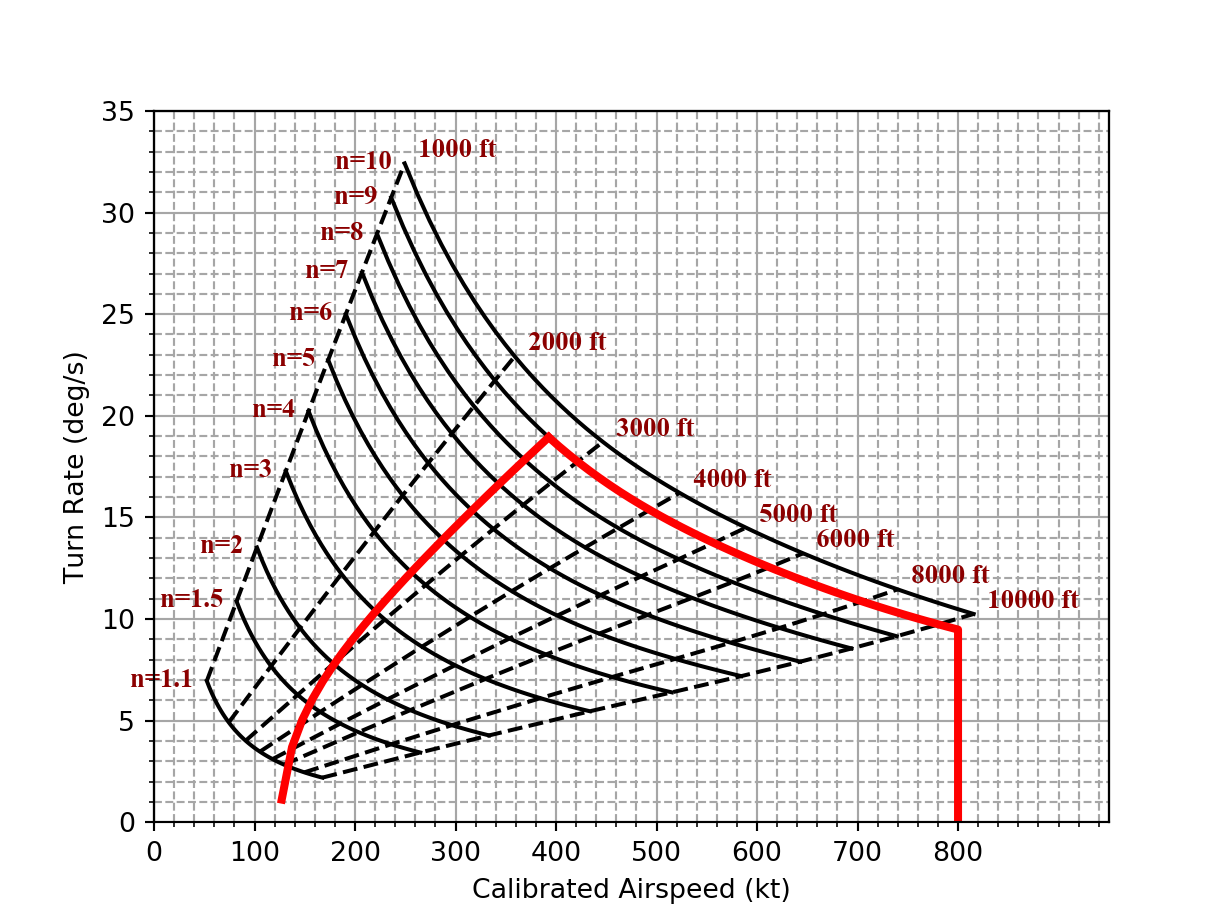

In [11]:
aircraft = F15()
altitude = 20000
weight = 39300
g_values = [1.1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]
radius_values = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000]

render(aircraft, altitude, weight, g_values, radius_values)